# Traffic Light Detection
using Tensorflow v1.x Object Detection API

## Environment Setup

### Install required libraries

In [1]:
# Colab default version is now 2.x, so uninstall it and install v1.14
%tensorflow_version 2.x
!pip uninstall -y tensorflow tensorboard tensorflow-estimator tensorboard-plugin-wit
!pip install tensorflow-gpu==1.14.0 tensorboard==1.14.0 tensorflow-estimator==1.14.0 
#!pip install tensorboard-plugin-wit==1.6.0.post3

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling tensorboard-2.3.0:
  Successfully uninstalled tensorboard-2.3.0
Uninstalling tensorflow-estimator-2.3.0:
  Successfully uninstalled tensorflow-estimator-2.3.0
Uninstalling tensorboard-plugin-wit-1.7.0:
  Successfully uninstalled tensorboard-plugin-wit-1.7.0
     |████████████████████████████████| 377.0MB 46kB/s 
     |████████████████████████████████| 3.2MB 34.1MB/s 
     |████████████████████████████████| 491kB 38.1MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [2]:
# Install necessary libraries
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q pillow lxml jupyter matplotlib cython pandas contextlib2
!pip install -q pycocotools tf_slim

Selecting previously unselected package python-bs4.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

### Set configurations

In [3]:
# Repo URL
repo_url = 'https://github.com/yuki678/driving-object-detection'

## Number of training and evaluation steps (override the setup in .config)
## Do not use these parameters as the lerning rate strategy would be different between models
# num_steps = 10000
# num_eval_steps = 500

# Models
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'model_path': '/models/tf1/my_ssd_mobilenet_v2/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 32
    },
    'faster_rcnn_resnet50_coco': {
        'model_name': 'faster_rcnn_resnet50_coco_2018_01_28',
        'model_path': '/models/tf1/my_faster_rcnn_resnet50_coco/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 16
    },
    'faster_rcnn_resnet101_kitti': {
        'model_name': 'faster_rcnn_resnet101_kitti_2018_01_28',
        'model_path': '/models/tf1/my_faster_rcnn_resnet101_kitti/',
        'pipeline_file': 'pipeline.config',
        'batch_size': 16
    }
}

# Select a model to use.
selected_model = 'ssd_mobilenet_v2'

model_name = MODELS_CONFIG[selected_model]['model_name']
model_path = MODELS_CONFIG[selected_model]['model_path']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
batch_size = MODELS_CONFIG[selected_model]['batch_size']

### Clone the project repository

In [4]:
import os
%cd /content

# Set Repository Home Directory
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

# Clone
!git clone {repo_url}

# Pull
%cd {repo_dir_path}
!git pull

/content
Cloning into 'driving-object-detection'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (429/429), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1287 (delta 263), reused 340 (delta 176), pack-reused 858
Receiving objects: 100% (1287/1287), 199.43 MiB | 25.45 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Checking out files: 100% (1173/1173), done.
/content/driving-object-detection
Already up to date.


In [5]:
# Set Label Map (.pbtxt) path and pipeline.config path
label_map_pbtxt_fname = repo_dir_path + '/annotations/label_map.pbtxt'
pipeline_fname = repo_dir_path + model_path + pipeline_file

assert os.path.isfile(label_map_pbtxt_fname), '`{}` not exist'.format(label_map_pbtxt_fname)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [6]:
# Check pipeline config - update if required
!cat {pipeline_fname}

model {
  ssd {
    num_classes: 3
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
      use_depthwise: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 

### Clone Tensorflow models

In [7]:
%cd /content
!git clone --quiet -b r1.13.0 https://github.com/tensorflow/models.git

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install .

# Test
!python object_detection/builders/model_builder_test.py

/content
/content/models/research
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=801478 sha256=a515fb10f833c78c4fb7100d4094c568f15f08947e65560a2c71ecbb8dff3b74
  Stored in directory: /tmp/pip-ephem-wheel-cache-jj3o1or5/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/

### COCO API Installation

In [8]:
%cd /content
!git clone --quiet https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
!cp -r pycocotools /content/models/research/

/content
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In functi

### Download Pretrained Model

In [9]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = model_name + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(model_name, DEST_DIR)

/content/models/research


In [10]:
# Check downloaded files
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 71 root   root  4.0K Sep  8 04:57 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [11]:
# Set fine tune checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Preprocess Images
This part can be skipped if image labels have already been converted to TFRecord files.

Assuming all images are under images/ directory with the labels in .xml files, generated by labelImg in format.

### Split to train set and test set

In [12]:
%cd {repo_dir_path}

# Split images to train:test = 9:1
!python scripts/partition_dataset.py -x -i images/ -r 0.1

# Check test images
!ls images/test

/content/driving-object-detection
 green_164.png			      red_353.xml   red_749.png
 green_164.xml			      red_357.jpg   red_749.xml
 green_175.png			      red_357.xml   yellow_836.jpg
 green_175.xml			      red_391.jpg   yellow_836.xml
 green_291.png			      red_391.xml   yellow_858.jpg
 green_291.xml			      red_405.jpg   yellow_858.xml
'image_2020-09-01 12:54:56.081.jpg'   red_405.xml   yellow_860.jpg
'image_2020-09-01 12:54:56.081.xml'   red_413.jpg   yellow_860.xml
 red_351.jpg			      red_413.xml   yellow_990.png
 red_351.xml			      red_706.png   yellow_990.xml
 red_353.jpg			      red_706.xml


### Convert .xml files to csv

In [13]:
# Create train data:
!python scripts/xml_to_csv.py -i images/train -o annotations/train_labels.csv

# Create test data:
!python scripts/xml_to_csv.py -i images/test -o annotations/test_labels.csv

Successfully converted xml to csv.
Successfully converted xml to csv.


### Convert to TFRecord format (.record)

In [14]:
!cat annotations/label_map.pbtxt

item {
    id: 1
    name: 'green'
}

item {
    id: 2
    name: 'yellow'
}

item {
    id: 3
    name: 'red'
}



In [15]:
# Create train data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/train_labels.csv \
    --output_path=annotations/train.record \
    --img_path=images/train \
    --label_map annotations/label_map.pbtxt

# Create test data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/test_labels.csv \
    --output_path=annotations/test.record \
    --img_path=images/test \
    --label_map annotations/label_map.pbtxt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [16]:
# Set .record path
test_record_fname = repo_dir_path + '/annotations/test.record'
train_record_fname = repo_dir_path + '/annotations/train.record'

assert os.path.isfile(test_record_fname), '`{}` not exist'.format(test_record_fname)
assert os.path.isfile(train_record_fname), '`{}` not exist'.format(train_record_fname)

## Training

### Set Training Output Directories

In [17]:
model_dir = repo_dir_path + '/training/'
output_dir = repo_dir_path + '/exported-models/'

!rm -rf {model_dir} {output_dir}
os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### Tensorboard

In [18]:
# Set log directory for tensorboard to watch
LOG_DIR = model_dir

# Clean up the directory
!rm -rf {LOG_DIR}/*

In [19]:
# Option A: Use ngrok tunneling
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-09-08 04:57:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.71.209.190, 34.198.20.103, 54.163.152.154, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.71.209.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  13.3MB/s    in 1.0s    

2020-09-08 04:57:14 (13.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [20]:
!sleep 2
get_ipython().system_raw(
    'tensorboard --logdir={} &'.format(LOG_DIR)
)

In [21]:
!sleep 2
get_ipython().system_raw('./ngrok http 6006 &')

In [22]:
!sleep 2
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


http://a307476f0bc8.ngrok.io


### Train!

In [23]:
%cd {repo_dir_path}
!git pull

/content/driving-object-detection
Already up to date.


In [24]:
!rm -rf {LOG_DIR}/*

In [25]:
!ls -lrt {LOG_DIR}

total 0


In [26]:
%cd {repo_dir_path}
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr

Streaming output truncated to the last 5000 lines.
2020-09-08 10:58:43.638851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1187]      0 
2020-09-08 10:58:43.638866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1200] 0:   N 
2020-09-08 10:58:43.639025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-08 10:58:43.639635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-08 10:58:43.640185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10805 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7)
INFO:tensorflow:Restoring parameters from /con

In [27]:
# Check the generated files
!ls -lrt {model_dir}

total 404060
-rw-r--r-- 1 root root 16434298 Sep  8 04:58 graph.pbtxt
drwxr-xr-x 2 root root     4096 Sep  8 05:08 eval_0
-rw-r--r-- 1 root root 65053064 Sep  8 12:28 model.ckpt-46040.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Sep  8 12:28 model.ckpt-46040.index
-rw-r--r-- 1 root root  8401008 Sep  8 12:28 model.ckpt-46040.meta
-rw-r--r-- 1 root root 65053064 Sep  8 12:38 model.ckpt-47058.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Sep  8 12:38 model.ckpt-47058.index
-rw-r--r-- 1 root root  8401008 Sep  8 12:38 model.ckpt-47058.meta
-rw-r--r-- 1 root root 65053064 Sep  8 12:48 model.ckpt-48078.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Sep  8 12:48 model.ckpt-48078.index
-rw-r--r-- 1 root root  8401008 Sep  8 12:48 model.ckpt-48078.meta
-rw-r--r-- 1 root root 65053064 Sep  8 12:58 model.ckpt-49099.data-00000-of-00001
-rw-r--r-- 1 root root    44531 Sep  8 12:58 model.ckpt-49099.index
-rw-r--r-- 1 root root  8401008 Sep  8 12:58 model.ckpt-49099.meta
-rw-r--r--

In [42]:
# Archive all the output
%cd {repo_dir_path}
!tar zcvf model_dir.tar.gz {model_dir}

/content/driving-object-detection
tar: Removing leading `/' from member names
/content/driving-object-detection/training/
/content/driving-object-detection/training/model.ckpt-48078.meta
/content/driving-object-detection/training/eval_0/
/content/driving-object-detection/training/eval_0/events.out.tfevents.1599541719.e807ecd8fe7d
/content/driving-object-detection/training/export/
/content/driving-object-detection/training/export/Servo/
/content/driving-object-detection/training/export/Servo/1599570466/
/content/driving-object-detection/training/export/Servo/1599570466/variables/
/content/driving-object-detection/training/export/Servo/1599570466/variables/variables.data-00000-of-00001
/content/driving-object-detection/training/export/Servo/1599570466/variables/variables.index
/content/driving-object-detection/training/export/Servo/1599570466/saved_model.pb
/content/driving-object-detection/training/graph.pbtxt
/content/driving-object-detection/training/model.ckpt-46040.meta
/content/dri

In [43]:
# Download the archive - you may need to run this cell twice as it often stuck before starting downloading
from google.colab import files
files.download('model_dir.tar.gz')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation (Optional)

This is not required as included in the previous script for training



## Export the output model

In [30]:
%cd {repo_dir_path}
import re
import numpy as np

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_dir} \
    --trained_checkpoint_prefix={last_model_path}

/content/driving-object-detection
/content/driving-object-detection/training/model.ckpt-50000
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6

In [31]:
# Check the output files
!echo {output_dir}
!ls -lsr {output_dir}

/content/driving-object-detection/exported-models/
total 33928
    4 drwxr-xr-x 3 root root     4096 Sep  8 13:08 saved_model
    4 -rw-r--r-- 1 root root     4071 Sep  8 13:08 pipeline.config
 1360 -rw-r--r-- 1 root root  1390129 Sep  8 13:08 model.ckpt.meta
   16 -rw-r--r-- 1 root root    15041 Sep  8 13:08 model.ckpt.index
15996 -rw-r--r-- 1 root root 16379432 Sep  8 13:08 model.ckpt.data-00000-of-00001
16544 -rw-r--r-- 1 root root 16938651 Sep  8 13:08 frozen_inference_graph.pb
    4 -rw-r--r-- 1 root root       77 Sep  8 13:08 checkpoint


### Archive the output directory

In [40]:
%cd {repo_dir_path}
!tar zcvf trained_model.tar.gz {output_dir}

/content/driving-object-detection
tar: Removing leading `/' from member names
/content/driving-object-detection/exported-models/
/content/driving-object-detection/exported-models/frozen_inference_graph.pb
/content/driving-object-detection/exported-models/model.ckpt.data-00000-of-00001
/content/driving-object-detection/exported-models/saved_model/
/content/driving-object-detection/exported-models/saved_model/variables/
/content/driving-object-detection/exported-models/saved_model/saved_model.pb
/content/driving-object-detection/exported-models/pipeline.config
/content/driving-object-detection/exported-models/checkpoint
/content/driving-object-detection/exported-models/model.ckpt.meta
/content/driving-object-detection/exported-models/model.ckpt.index


### Download the archive

In [41]:
# Download the .tar.gz archive - you may need to run this cell twice as it often stuck before starting downloading
from google.colab import files
files.download('trained_model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## Prediction using the trained model

### Set images for the inference

In [34]:
IMAGE_DIR = os.path.join(repo_dir_path, "images", "test")
IMAGE_PATHS = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith(".jpg") or file.endswith(".png"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))

IMAGE_PATHS

['/content/driving-object-detection/images/test/red_413.jpg',
 '/content/driving-object-detection/images/test/image_2020-09-01 12:54:56.081.jpg',
 '/content/driving-object-detection/images/test/red_405.jpg',
 '/content/driving-object-detection/images/test/yellow_990.png',
 '/content/driving-object-detection/images/test/red_357.jpg',
 '/content/driving-object-detection/images/test/red_706.png',
 '/content/driving-object-detection/images/test/yellow_860.jpg',
 '/content/driving-object-detection/images/test/red_391.jpg',
 '/content/driving-object-detection/images/test/green_175.png',
 '/content/driving-object-detection/images/test/red_749.png',
 '/content/driving-object-detection/images/test/yellow_858.jpg',
 '/content/driving-object-detection/images/test/green_291.png',
 '/content/driving-object-detection/images/test/red_353.jpg',
 '/content/driving-object-detection/images/test/red_351.jpg',
 '/content/driving-object-detection/images/test/yellow_836.jpg',
 '/content/driving-object-detect

In [35]:
# Label Map path
PATH_TO_LABELS = label_map_pbtxt_fname

In [36]:
PATH_TO_CKPT = os.path.join(os.path.abspath(output_dir), "frozen_inference_graph.pb")

### Load the trained model and predict!!

/content/models/research/object_detection


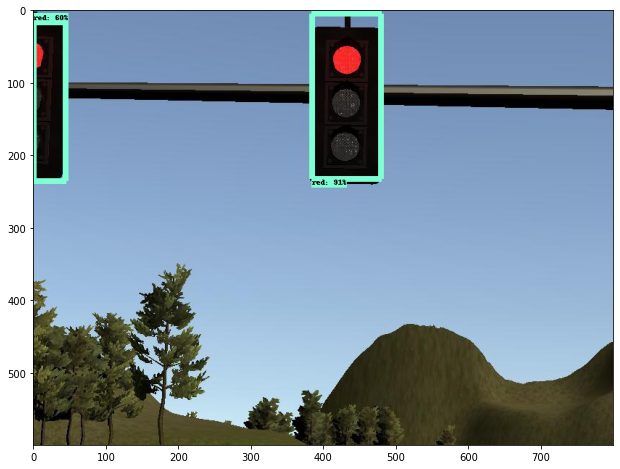

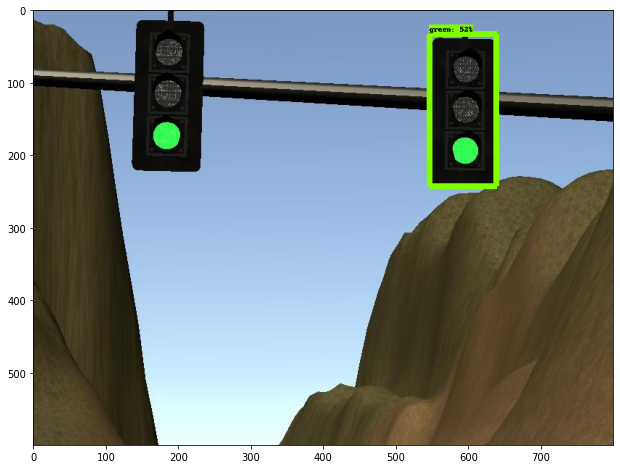

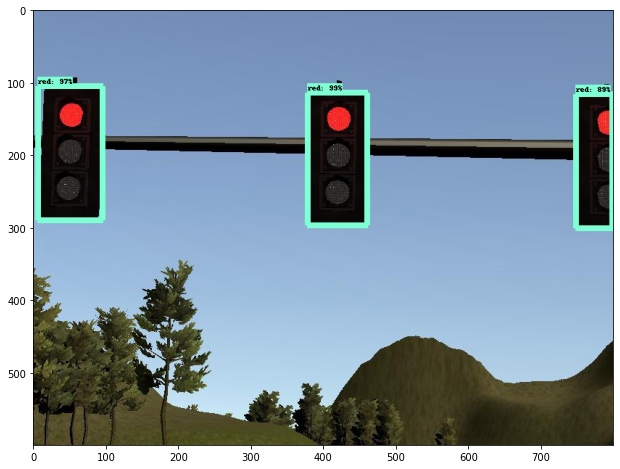

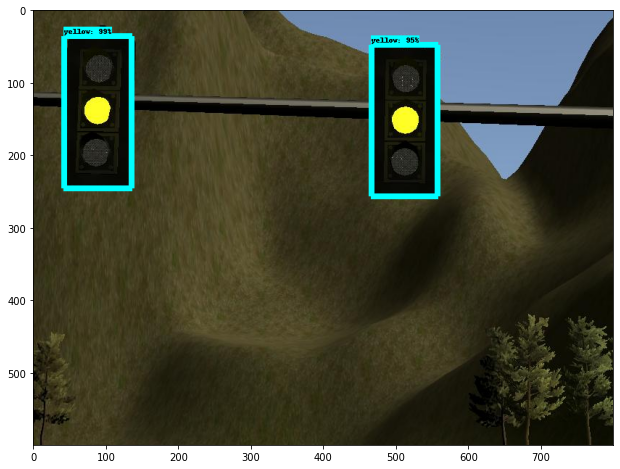

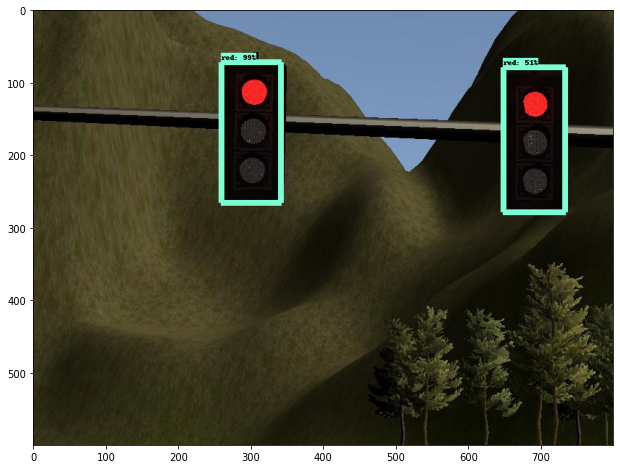

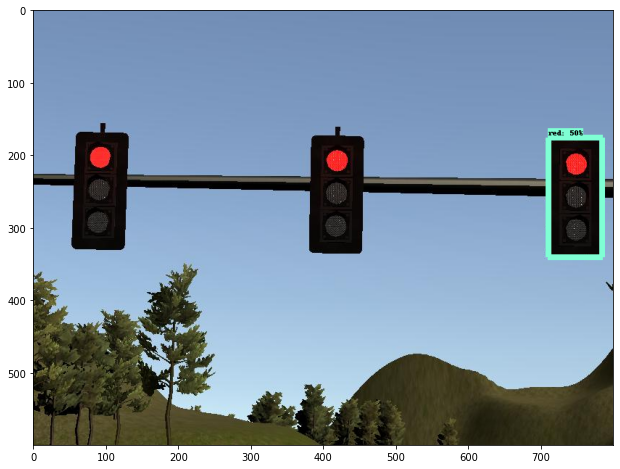

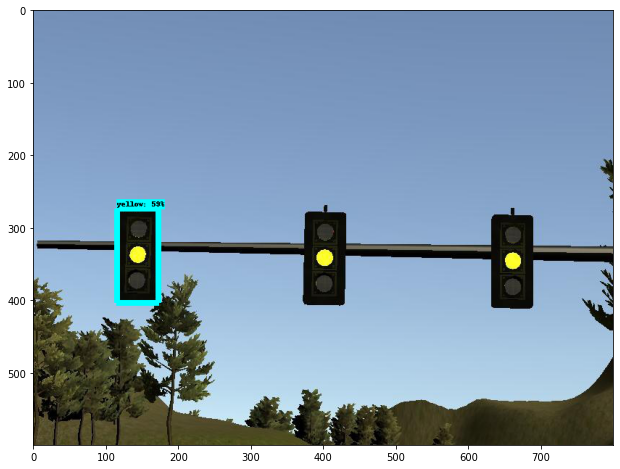

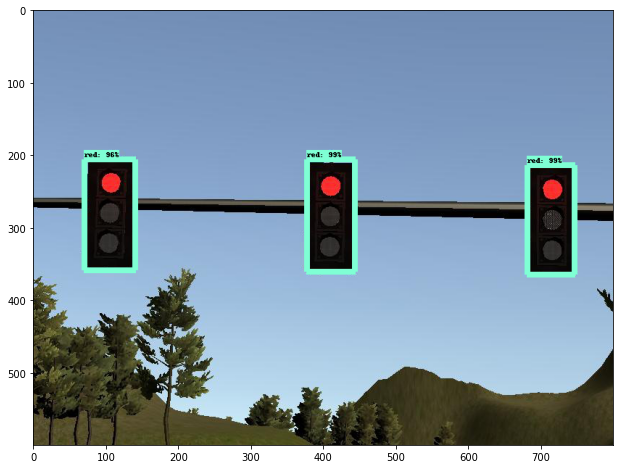

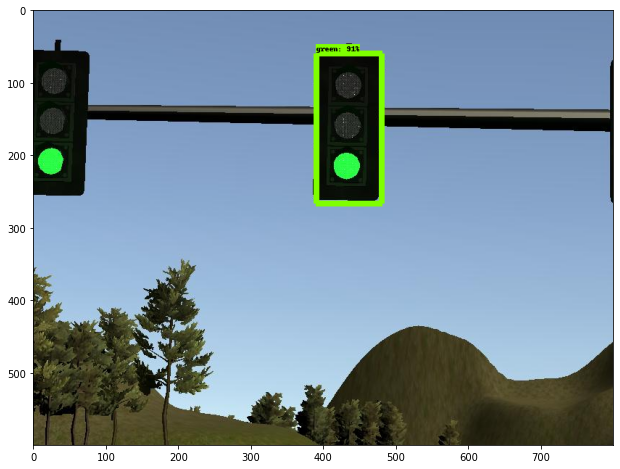

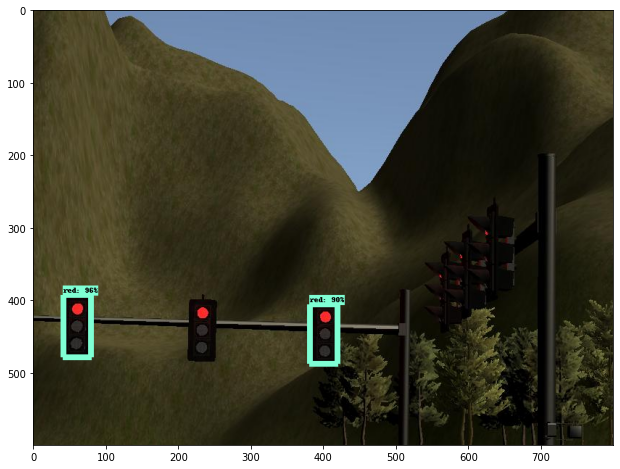

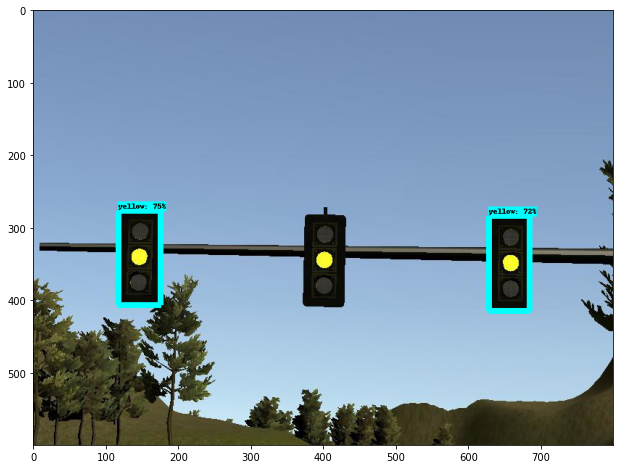

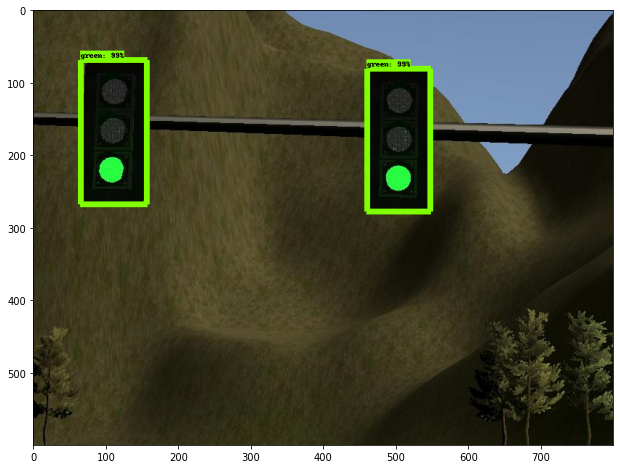

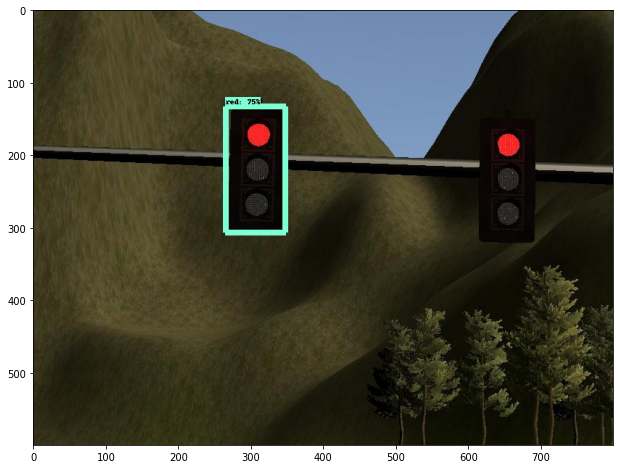

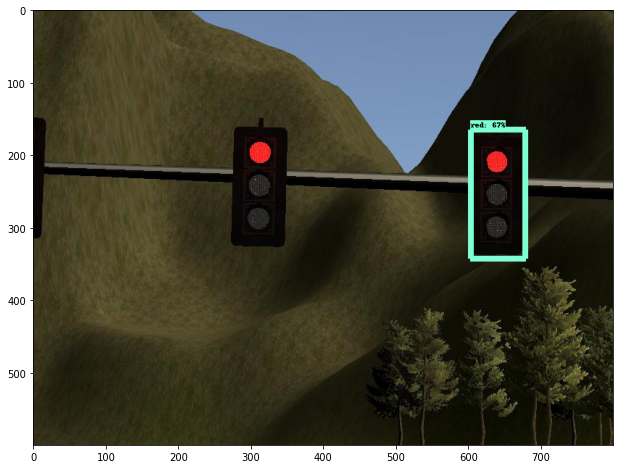

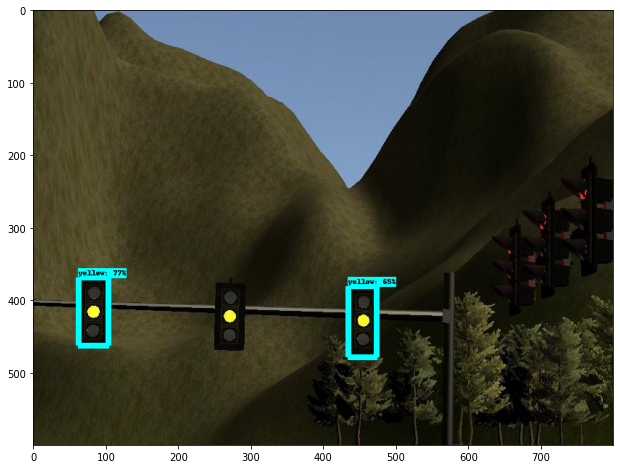

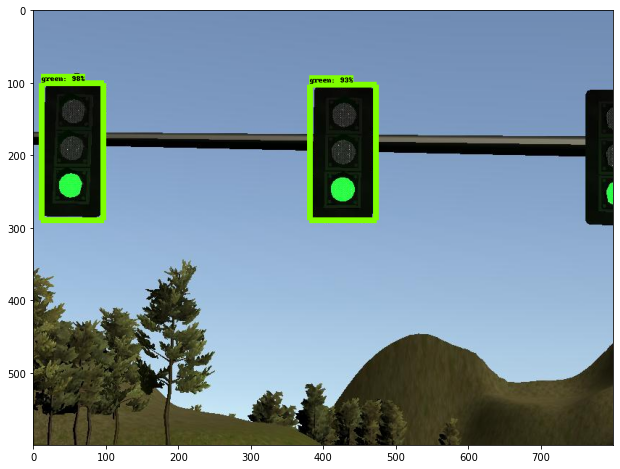

In [44]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

num_classes = 3

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)